In [2]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
import numpy as np
from astropy.coordinates import angular_separation
from scipy.stats import linregress
import astropy.io.fits as fits
from reproject import reproject_from_healpix
from matplotlib import pyplot as plt
from scipy.interpolate import interpn
from pygdsm import GlobalSkyModel
from reproject import reproject_to_healpix
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS
from astropy import units as units
from importlib import reload
import numpy.ma as ma
import astropy.units as u
import copy
from fractions import Fraction
from matplotlib.ticker import MultipleLocator, FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import healpy
from scipy.stats import gaussian_kde
def piformat(x,pos):
    frac = Fraction(numerator=x/np.pi)
    if frac.denominator == 1:
        if frac.numerator == 0:
            return '$0$'
        if frac.numerator == 1:
            return '$\pi$'
        if frac.numerator == -1:
            return '$-\pi$'
        return '$' + '{:g}'.format(frac.numerator) + '\pi$'
    if frac.numerator == 1:
        return '$\pi / ' + '{:g}'.format(frac.denominator) + '$'
    if frac.numerator == -1:
        return '$-\pi / ' + '{:g}'.format(frac.denominator) + '$'
    return '$' + '{:g}'.format(frac.numerator) + '\pi / ' + '{:g}'.format(frac.denominator) + '$'
import healpy as hp

In [3]:
fn = '/srv/data/chime/tadpole_cutout_Mar2024/IQUV_400_729/Q_400_729_Mar2024_tadpole_gal.fits'
hdr_chimeQ = fits.getheader(fn)
chimeQ = fits.getheader(fn)
wcs_chime = WCS(hdr_chimeQ)

fn = '/srv/data/chime/tadpole_cutout_Mar2024/IQUV_400_729/U_400_729_Mar2024_tadpole_gal.fits'
hdr_chimeU = fits.getheader(fn)
chimeU = fits.getdata(fn)

In [4]:
xpix_gal, ypix_gal = wcs_chime.celestial.wcs_world2pix(137.45706817862768,7.06094581066827, 1)
xpix_gal = np.fix(xpix_gal)
ypix_gal = np.fix(ypix_gal)
xpix_gal, ypix_gal

s=100
ymin=ypix_gal-s; ymax=ypix_gal+s; xmin=xpix_gal-s; xmax=xpix_gal+s;


In [5]:
fn = '/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/FDF_peakRM.fits'
hdr_peak = fits.getheader(fn)
peak_map = fits.getdata(fn)

In [7]:
fn = '/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/FDF_clean_real.fits'
hdr_fd_q = fits.getheader(fn)
fd_q_map = fits.getdata(fn)
print(fd_q_map.shape)

fn = '/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/FDF_clean_im.fits'
hdr_fd_u = fits.getheader(fn)
fd_u_map = fits.getdata(fn)
wcs_fd_u = WCS(hdr_fd_u)

(801, 250, 250)


In [8]:
pI_fd = np.sqrt(fd_q_map**2 + fd_u_map**2)

In [9]:
fn = '/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/dirty_polAngle0Fit_deg.fits'
hdr_fd_chi = fits.getheader(fn)
chi_fd = fits.getdata(fn)
wcs_fd_chi = WCS(hdr_fd_chi)

In [10]:
_2moment_0_pI = pI_fd

moment_0 = np.nansum(_2moment_0_pI[381:411], axis=0)*10.55 #times the RMSF
print(moment_0.shape)

(250, 250)


In [17]:
xhead_chime, yhead_chime = np.fix(wcs_chime.celestial.wcs_world2pix(137.08,7.2, 1))
xtail_chime, ytail_chime = np.fix(wcs_chime.celestial.wcs_world2pix(134,6.6, 1))
xoff_chime,  yoff_chime  = np.fix(wcs_chime.celestial.wcs_world2pix(135,9.5, 1))

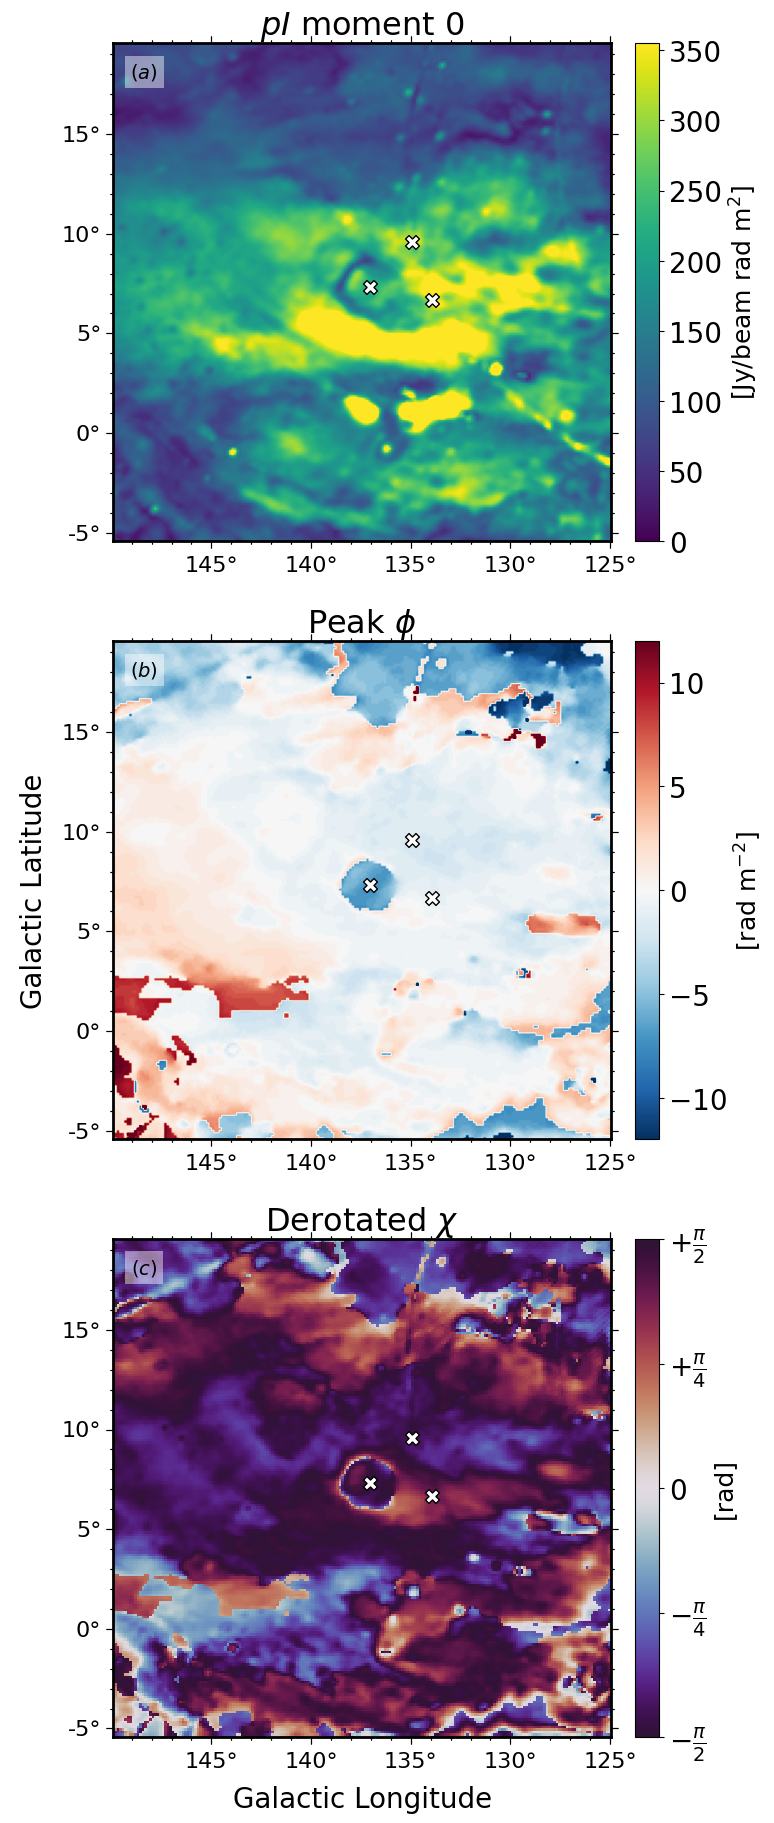

In [18]:
fig = plt.figure(figsize=(15, 22))

#------------------------------------------- FD Cube
#----------------------------------------------------------------- M0
ax = fig.add_subplot(311, projection=wcs_chime.celestial)  # Changed from 231 to 321
im = ax.imshow(moment_0, cmap='viridis', vmin=0, vmax=355)
#ax.scatter(xpix_gal, ypix_gal,       c='white', s=100, marker='x', zorder=10)
ax.scatter(xhead_chime, yhead_chime,  c='white',s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xtail_chime, ytail_chime,  c='white',s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xoff_chime, yoff_chime,    c='white',s=100, marker='X',edgecolor='black',zorder=10)
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_title(r"$pI$ moment 0", fontsize=23)
ax.set_aspect(np.abs(wcs_chime.wcs.cdelt[1] / wcs_chime.wcs.cdelt[0]))

ax.set_xlabel(" ", fontsize=20)
ax.set_ylabel(" ", fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=16, zorder=30, length=5)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.coords.frame.set_linewidth(2)
t=plt.text(wcs_chime.wcs_world2pix(148.5, 1, 1, 1)[0], wcs_chime.wcs_world2pix(1, 18, 1, 1)[1],
        r'$(a)$', fontsize=14, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'none'}, ha='center', va='center')

cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r"[Jy/beam rad m$^{2}$]", fontsize=18) #Whatever ST units are

#----------------------------------------------------------------- 

ax = fig.add_subplot(312, projection=wcs_chime.celestial)  # Changed from 231 to 321
im = ax.imshow(peak_map[0], cmap='RdBu_r', vmin=-12, vmax=12)
#ax.scatter(xpix_gal, ypix_gal,       c='white', s=100, marker='x', zorder=10)
ax.scatter(xhead_chime, yhead_chime, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xtail_chime, ytail_chime, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xoff_chime, yoff_chime,   c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_title("Peak $\phi$", fontsize=23)
ax.set_aspect(np.abs(wcs_chime.wcs.cdelt[1] / wcs_chime.wcs.cdelt[0]))
t=plt.text(wcs_chime.wcs_world2pix(148.5, 1, 1, 1)[0], wcs_chime.wcs_world2pix(1, 18, 1, 1)[1],
        r'$(b)$', fontsize=14, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'none'}, ha='center', va='center')
ax.set_xlabel(" ", fontsize=20)
ax.set_ylabel("Galactic Latitude", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=16, zorder=30, length=5)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.coords.frame.set_linewidth(2)

cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r"[rad m$^{-2}$]", fontsize=18) #Whatever ST units are





#-------------------------------------------

ax = fig.add_subplot(313, projection=wcs_fd_u.celestial)  # Changed from 231 to 321
im = ax.imshow(chi_fd/180*np.pi-np.pi/2, cmap='twilight_shifted', vmin=-np.pi/2, vmax=np.pi/2, interpolation='none')
#ax.scatter(xpix_gal, ypix_gal,       c='white', s=100, marker='x', zorder=10)
ax.scatter(xhead_chime, yhead_chime,  c='white',s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xtail_chime, ytail_chime,  c='white',s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xoff_chime, yoff_chime,    c='white',s=100, marker='X',edgecolor='black',zorder=10)
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_title("Derotated $\chi$", fontsize=23)
ax.set_aspect(np.abs(wcs_chime.wcs.cdelt[1] / wcs_chime.wcs.cdelt[0]))
t=plt.text(wcs_chime.wcs_world2pix(148.5, 1, 1, 1)[0], wcs_chime.wcs_world2pix(1, 18, 1, 1)[1],
        r'$(c)$', fontsize=14, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'none'}, ha='center', va='center')
ax.set_xlabel("Galactic Longitude", fontsize=20)
ax.set_ylabel(" ", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=16, zorder=30, length=5)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.coords.frame.set_linewidth(2)

cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02, ticks=[-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_yticklabels([r"$-\frac{\pi}{2}$", r"$-\frac{\pi}{4}$", r"$0$", r"$+\frac{\pi}{4}$", r"$+\frac{\pi}{2}$"])
cbar.set_label(r"[rad]", fontsize=18)



#plt.savefig('/srv/nmohamme/notebooks/Fall2023/Paper_update/figures_Mar2024/fig3.pdf', bbox_inches='tight', pad_inches=0.1)

In [19]:
fn = ('/srv/nmohamme/data2/WSRT_PI150M_FDF.gal.FITS')
hdr_wsrt150_pI = fits.getheader(fn)
wsrt150_pI = fits.getdata(fn)
wcs_wsrt150=WCS(hdr_wsrt150_pI)

In [20]:
xpix_150, ypix_150 = np.fix(wcs_wsrt150.celestial.wcs_world2pix(137.45706817862768,7.06094581066827, 1))

ymin_150 = int(wcs_wsrt150.wcs_world2pix(128, 2, 1, 1)[1])
ymax_150 = int(wcs_wsrt150.wcs_world2pix(128, 11, 1, 1)[1])
xmin_150 = int(wcs_wsrt150.wcs_world2pix(128, 11, 1,1)[0])
xmax_150 = int(wcs_wsrt150.wcs_world2pix(141, 11, 1,1)[0])

In [24]:
xpix_gal, ypix_gal = np.fix(wcs_chime.celestial.wcs_world2pix(137.45706817862768,7.06094581066827, 1))

ymin_chime = int(wcs_chime.wcs_world2pix(1, 2, 1, 1)[1])
ymax_chime = int(wcs_chime.wcs_world2pix(1, 11, 1, 1)[1])
xmin_chime = int(wcs_chime.wcs_world2pix(128, 1, 1, 1)[0])
xmax_chime = int(wcs_chime.wcs_world2pix(141, 1, 1, 1)[0])

In [22]:
xhead_chime, yhead_chime = np.fix(wcs_chime.celestial.wcs_world2pix(137.08,7.2, 1))
xtail_chime, ytail_chime = np.fix(wcs_chime.celestial.wcs_world2pix(134,6.6, 1))
xoff_chime, yoff_chime = np.fix(wcs_chime.celestial.wcs_world2pix(135,9.5, 1))

xhead_wsrt, yhead_wsrt = np.fix(wcs_wsrt150.celestial.wcs_world2pix(137.08,7.2, 1))
xtail_wsrt, ytail_wsrt = np.fix(wcs_wsrt150.celestial.wcs_world2pix(134,6.6, 1))
xoff_wsrt, yoff_wsrt = np.fix(wcs_wsrt150.celestial.wcs_world2pix(135,9.5, 1))

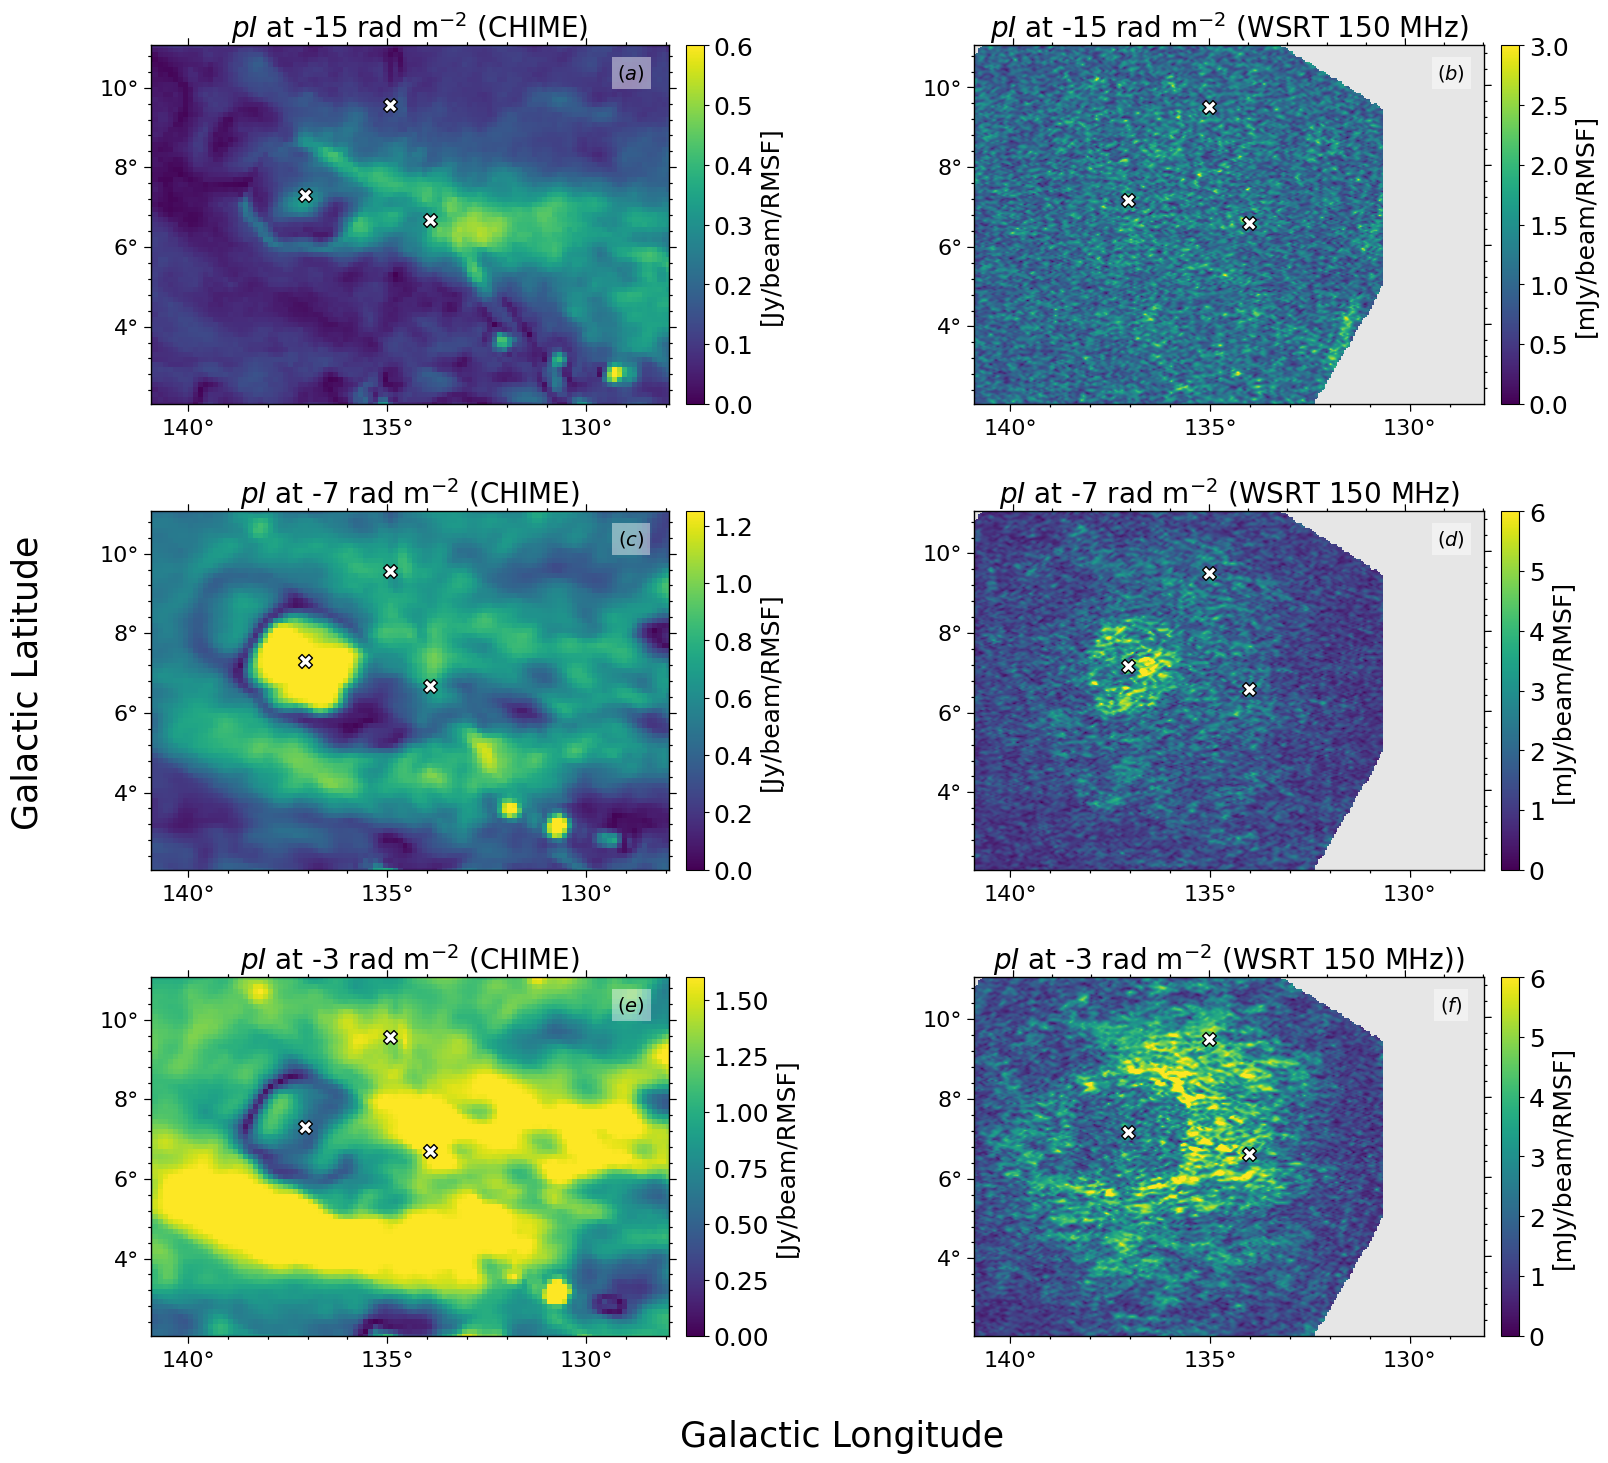

In [26]:
fig = plt.figure(figsize=(18*1.2, 10.5*1.33*1.2))

ax = fig.add_subplot(321, projection=wcs_chime.celestial)

im = ax.imshow(pI_fd[371], cmap='viridis', vmin=0, vmax=0.6)
ax.scatter(xhead_chime, yhead_chime, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xtail_chime, ytail_chime, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xoff_chime, yoff_chime  , c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.set_ylim(ymin_chime, ymax_chime)
ax.set_xlim(xmax_chime, xmin_chime)
ax.set_title(r'$pI$ at -15 rad m$^{-2}$ (CHIME)', fontsize=20)
ax.set_aspect(np.abs(wcs_chime.wcs.cdelt[1] / wcs_chime.wcs.cdelt[0]))
ax.set_xlabel(" ", fontsize=20)
ax.set_ylabel(" ", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16, zorder=30, length=5)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.coords.frame.set_linewidth(1)
cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r"[Jy/beam/RMSF]", fontsize=18)
ax.text(wcs_chime.celestial.wcs_world2pix(129, 1, 1)[0], wcs_chime.celestial.wcs_world2pix(1, 10.25, 1)[1],
        r'$(a)$', fontsize=14, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'none'}, ha='center', va='center')


ax = fig.add_subplot(322, projection=WCS(hdr_wsrt150_pI).celestial)

im = ax.imshow(wsrt150_pI[36]*1000, cmap='viridis', vmin=0,vmax=0.003*1000)
ax.scatter(xhead_wsrt, yhead_wsrt, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xtail_wsrt, ytail_wsrt, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter( xoff_wsrt,  yoff_wsrt, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.set_ylim(ymin_150, ymax_150)
ax.set_xlim(xmax_150, xmin_150)
ax.set_title(r'$pI$ at -15 rad m$^{-2}$ (WSRT 150 MHz)', fontsize=20)
ax.set_aspect(np.abs(wcs_chime.wcs.cdelt[1] / wcs_chime.wcs.cdelt[0]))
ax.set_xlabel(" ", fontsize=20)
ax.set_ylabel(" ", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16, zorder=30, length=5)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.coords.frame.set_linewidth(1)
cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r"[mJy/beam/RMSF]", fontsize=18)
ax.set_facecolor('0.9')
ax.text(wcs_wsrt150.wcs_world2pix(129, 1, 1, 1)[0], wcs_wsrt150.wcs_world2pix(1, -0.6, 1, 1)[1],
        r'$(b)$', fontsize=14, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'none'}, ha='center', va='center')

ax = fig.add_subplot(323, projection=wcs_chime.celestial)

im = ax.imshow(pI_fd[387], cmap='viridis', vmin=0, vmax=1.25)
ax.scatter(xhead_chime, yhead_chime, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xtail_chime, ytail_chime, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xoff_chime, yoff_chime  , c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.set_ylim(ymin_chime, ymax_chime)
ax.set_xlim(xmax_chime, xmin_chime)
ax.set_title(r'$pI$ at -7 rad m$^{-2}$ (CHIME)', fontsize=20)
ax.set_aspect(np.abs(wcs_chime.wcs.cdelt[1] / wcs_chime.wcs.cdelt[0]))
ax.set_xlabel(" ", fontsize=20)
ax.set_ylabel(" ", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16, zorder=30, length=5)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.coords.frame.set_linewidth(1)
cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r"[Jy/beam/RMSF]", fontsize=18)
ax.text(wcs_chime.celestial.wcs_world2pix(129, 1, 1)[0], wcs_chime.celestial.wcs_world2pix(1, 10.25, 1)[1],
        r'$(c)$', fontsize=14, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'none'}, ha='center', va='center')


ax = fig.add_subplot(324, projection=WCS(hdr_wsrt150_pI).celestial)

im = ax.imshow(wsrt150_pI[44]*1000, cmap='viridis', vmin=0,vmax=0.006*1000)
#ax.scatter(xpix_150, ypix_150,       c='white', s=100, marker='x', zorder=10)
ax.scatter(xhead_wsrt, yhead_wsrt, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xtail_wsrt, ytail_wsrt, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter( xoff_wsrt,  yoff_wsrt, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.set_ylim(ymin_150, ymax_150)
ax.set_xlim(xmax_150, xmin_150)
ax.set_title(r'$pI$ at -7 rad m$^{-2}$ (WSRT 150 MHz)', fontsize=20)
ax.set_aspect(np.abs(wcs_chime.wcs.cdelt[1] / wcs_chime.wcs.cdelt[0]))
ax.set_xlabel(" ", fontsize=20)
ax.set_ylabel(" ", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16, zorder=30, length=5)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.coords.frame.set_linewidth(1)
cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r"[mJy/beam/RMSF]", fontsize=18)
ax.set_facecolor('0.9')
ax.text(wcs_wsrt150.wcs_world2pix(129, 1, 1, 1)[0], wcs_wsrt150.wcs_world2pix(1, -0.6, 1, 1)[1],
        r'$(d)$', fontsize=14, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'none'}, ha='center', va='center')


ax = fig.add_subplot(325, projection=wcs_chime.celestial)

im = ax.imshow(pI_fd[395], cmap='viridis', vmin=0, vmax=1.6)
ax.scatter(xhead_chime, yhead_chime, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xtail_chime, ytail_chime, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xoff_chime, yoff_chime , c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.set_ylim(ymin_chime, ymax_chime)
ax.set_xlim(xmax_chime, xmin_chime)
ax.set_title(r'$pI$ at -3 rad m$^{-2}$ (CHIME)', fontsize=20)
ax.set_aspect(np.abs(wcs_chime.wcs.cdelt[1] / wcs_chime.wcs.cdelt[0]))
ax.set_xlabel(" ", fontsize=20)
ax.set_ylabel(" ", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16, zorder=30, length=5)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.coords.frame.set_linewidth(1)
cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r"[Jy/beam/RMSF]", fontsize=18)
ax.text(wcs_chime.celestial.wcs_world2pix(129, 1, 1)[0], wcs_chime.celestial.wcs_world2pix(1, 10.25, 1)[1],
        r'$(e)$', fontsize=14, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'none'}, ha='center', va='center')


ax = fig.add_subplot(326, projection=WCS(hdr_wsrt150_pI).celestial)

im = ax.imshow(wsrt150_pI[48]*1000, cmap='viridis', vmin=0,vmax=0.006*1000)
#ax.scatter(xpix_150, ypix_150,       c='white', s=100, marker='x', zorder=10)
ax.scatter(xhead_wsrt, yhead_wsrt, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xtail_wsrt, ytail_wsrt, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter( xoff_wsrt,  yoff_wsrt, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.set_ylim(ymin_150, ymax_150)
ax.set_xlim(xmax_150, xmin_150)
ax.set_title(r'$pI$ at -3 rad m$^{-2}$ (WSRT 150 MHz))', fontsize=20)
ax.set_aspect(np.abs(wcs_chime.wcs.cdelt[1] / wcs_chime.wcs.cdelt[0]))
ax.set_xlabel(" ", fontsize=20)
ax.set_ylabel(" ", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16, zorder=30, length=5)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.coords.frame.set_linewidth(1)
cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r"[mJy/beam/RMSF]", fontsize=18)
ax.set_facecolor('0.9')
ax.text(wcs_wsrt150.wcs_world2pix(129, 1, 1, 1)[0], wcs_wsrt150.wcs_world2pix(1, -0.6, 1, 1)[1],
        r'$(f)$', fontsize=14, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'none'}, ha='center', va='center')
        
fig.supylabel('Galactic Latitude', fontsize=25, x=0.15)
fig.supxlabel('Galactic Longitude', fontsize=25, y=0.04, x=0.535)

fig.subplots_adjust(wspace=-0.05)
fig.subplots_adjust(hspace=0.3)

plt.savefig('/srv/nmohamme/notebooks/Fall2023/Paper_update/figures_Mar2024/fig6.pdf', bbox_inches='tight', pad_inches=0.1)

